In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2

from tensorflow import keras
from math import ceil
from numba import njit, prange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

In [2]:
Welding_data = np.load('E:/Result/ver.3.29/MTF/MTF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [3]:
from sklearn.model_selection import train_test_split

rs = 7

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= rs)

#X_train = X_train.reshape(-1, 300, 300, 2) / 255.0

In [4]:
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= rs)

In [5]:
print(X_train.shape, X_val.shape)

(2263, 100, 100, 2) (566, 100, 100, 2)


In [11]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16, kernel_size= 3, activation= 'relu', padding= 'same', input_shape=(100, 100, 2)))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(32, kernel_size= 3, activation= 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(128, kernel_size= 3, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(256, kernel_size= 3, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(512, kernel_size= 3, activation = 'relu', padding= 'same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(3, activation= 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      304       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 64)      

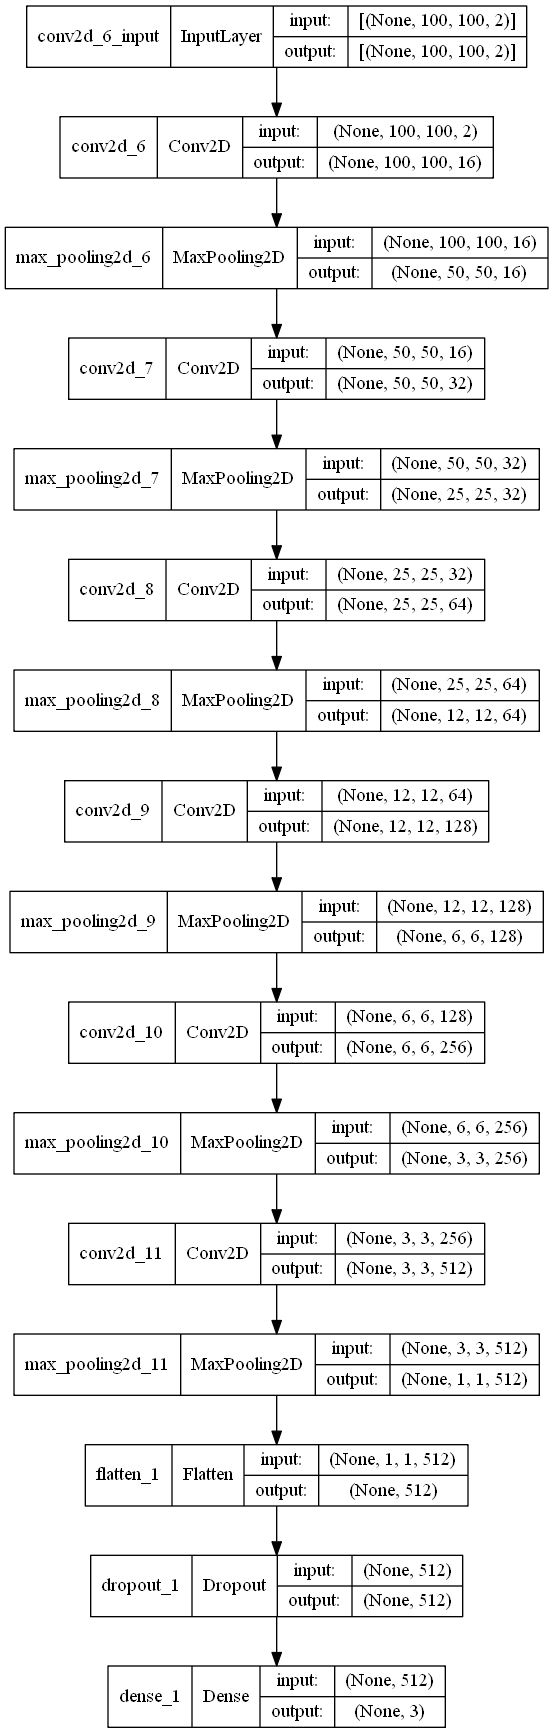

In [12]:
keras.utils.plot_model(model, show_shapes= True, to_file= 'self_CNN.png')

In [14]:
model.compile(
    optimizer= 'adam',
    loss= 'sparse_categorical_crossentropy',
    metrics= 'accuracy'
)

check_point_cb = keras.callbacks.ModelCheckpoint(
    'self_CNN.h5',
    save_best_only = True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience= 4,
    restore_best_weights= True
)

In [15]:
with tf.device('/gpu:0'):
    history = model.fit(
        X_train, y_train,
        epochs= 100,
        verbose= 1,
        validation_data= (X_val, y_val),
        callbacks= [check_point_cb,early_stopping_cb]
    )

Epoch 1/100
71/71 [==============================] - 4s 18ms/step - loss: 0.9092 - accuracy: 0.5347 - val_loss: 0.6446 - val_accuracy: 0.6820
Epoch 2/100
71/71 [==============================] - 1s 11ms/step - loss: 0.6374 - accuracy: 0.6907 - val_loss: 0.5421 - val_accuracy: 0.7155
Epoch 3/100
71/71 [==============================] - 1s 11ms/step - loss: 0.5430 - accuracy: 0.7349 - val_loss: 0.5222 - val_accuracy: 0.7438
Epoch 4/100
71/71 [==============================] - 1s 11ms/step - loss: 0.5341 - accuracy: 0.7411 - val_loss: 0.4745 - val_accuracy: 0.7703
Epoch 5/100
71/71 [==============================] - 1s 10ms/step - loss: 0.4869 - accuracy: 0.7503 - val_loss: 0.4763 - val_accuracy: 0.7473
Epoch 6/100
71/71 [==============================] - 1s 11ms/step - loss: 0.4789 - accuracy: 0.7631 - val_loss: 0.4553 - val_accuracy: 0.7509
Epoch 7/100
71/71 [==============================] - 1s 10ms/step - loss: 0.4821 - accuracy: 0.7684 - val_loss: 0.5910 - val_accuracy: 0.6396
Epoch 

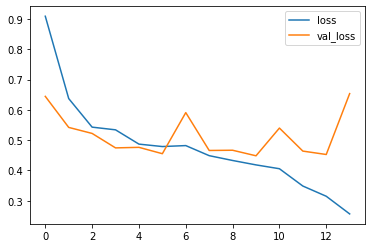

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [17]:
model.evaluate(X_val, y_val)

18/18 [==============================] - 0s 10ms/step - loss: 0.4484 - accuracy: 0.7933


[0.4483529329299927, 0.7932862043380737]

In [71]:
preds= model.predict(X_val[3:4])
print(preds[0])

[9.9679393e-01 4.1303856e-04 2.7930059e-03]


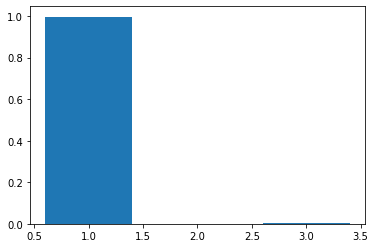

In [72]:
plt.bar(range(1,4), preds[0])
plt.show()

In [73]:
classes = ['Normal', 'Porosity', 'Humping']

In [74]:
print(classes[np.argmax(preds)])

Normal


In [18]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 2), dtype=tf.float32, name='conv2d_6_input'), name='conv2d_6_input', description="created by layer 'conv2d_6_input'")


In [25]:
model = keras.models.load_model('self_CNN.h5')

In [26]:
model.layers

In [75]:
conv = model.layers[4]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 32, 64) (64,)


In [76]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.009857782 0.054928884


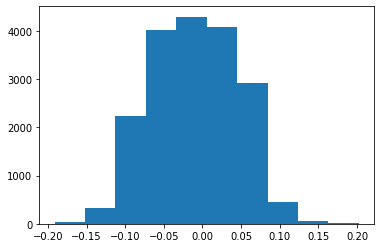

In [77]:
plt.hist(conv_weights.reshape(-1,1))
plt.show()

In [32]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 2), dtype=tf.float32, name='conv2d_6_input'), name='conv2d_6_input', description="created by layer 'conv2d_6_input'")


In [90]:
conv_acti = keras.Model(model.input, model.layers[10].output)

In [91]:
inputs = X_train[0:1].reshape(-1, 100, 100, 2)
feature_maps = conv_acti(inputs)

In [92]:
print(feature_maps.shape)

(1, 3, 3, 512)


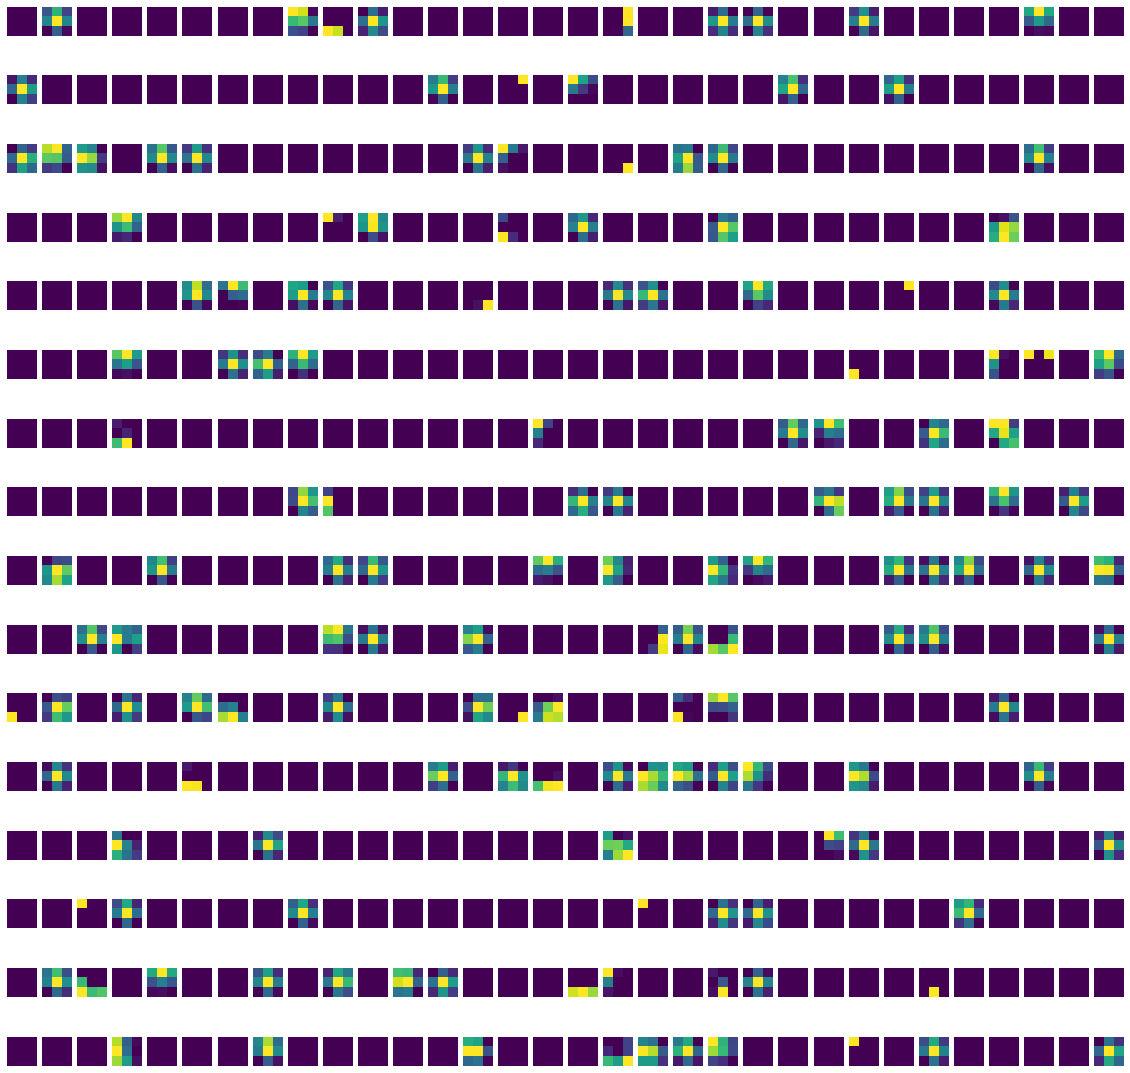

In [94]:
fig, axs= plt.subplots(16, 32, figsize=(20,20))

for i in range(16):
    for j in range(32):
        axs[i, j].imshow(feature_maps[0, :, :, i*32+j])
        axs[i,j].axis('off')
plt.show()

In [55]:
from PIL import Image

sample = X_val[0]
print(sample)
sample_img= Image.fromarray(sample.astype(np.uint8))

#sample_img.save('sample.png')
#sample_img.show()

[[[0.23076923 0.23076923]
  [0.23076923 0.23076923]
  [0.23076923 0.30769232]
  ...
  [0.07692308 0.15384616]
  [0.         0.        ]
  [0.07692308 0.        ]]

 [[0.23076923 0.23076923]
  [0.23076923 0.23076923]
  [0.23076923 0.30769232]
  ...
  [0.07692308 0.15384616]
  [0.         0.        ]
  [0.07692308 0.        ]]

 [[0.16666667 0.16666667]
  [0.16666667 0.16666667]
  [0.41666666 0.33333334]
  ...
  [0.         0.        ]
  [0.         0.08333334]
  [0.         0.        ]]

 ...

 [[0.         0.08333334]
  [0.         0.08333334]
  [0.08333334 0.        ]
  ...
  [0.33333334 0.33333334]
  [0.33333334 0.25      ]
  [0.33333334 0.16666667]]

 [[0.08333334 0.        ]
  [0.08333334 0.        ]
  [0.08333334 0.        ]
  ...
  [0.33333334 0.30769232]
  [0.33333334 0.3846154 ]
  [0.33333334 0.15384616]]

 [[0.         0.        ]
  [0.         0.        ]
  [0.08333334 0.        ]
  ...
  [0.33333334 0.        ]
  [0.33333334 0.        ]
  [0.33333334 0.5       ]]]
